In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import roc_curve, auc
from sklearn.exceptions import NotFittedError
import pickle
import gc
from datetime import datetime
from sklearn.metrics import confusion_matrix, precision_recall_curve

In [ ]:
#Set style for better visualizations
plt.style.use('seaborn')
sns.set_theme(style="whitegrid")

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

/tmp/ipykernel_30/366650319.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


**Load and Validate Packet Data**

In [72]:
useful_columns = [
    'generated', 'appName', 'totalSourceBytes', 'totalDestinationBytes',
    'totalDestinationPackets', 'totalSourcePackets', 'direction',
    'sourceTCPFlagsDescription', 'destinationTCPFlagsDescription',
    'source', 'protocolName', 'sourcePort', 'destination',
    'destinationPort', 'startDateTime', 'stopDateTime', 'Label'
]

def optimize_dtypes(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype('category')
        elif df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
        elif df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
    return df

def load_multiple_csv_files(file_paths):
    """Load and combine multiple CSV files"""
    dataframes = []
    for file_path in file_paths:
        try:
            df = pd.read_csv(file_path, usecols=useful_columns)
            df = optimize_dtypes(df)
            print(f"Loaded {file_path}: {len(df)} records")
            dataframes.append(df)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    if not dataframes:
        raise ValueError("No valid CSV files were loaded")
    
    combined_df = pd.concat(dataframes, ignore_index=True)
    print(combined_df.head())
    print(f"\nTotal combined records: {len(combined_df)}")
    return combined_df

csv_files = [
    '/kaggle/input/traindata/TestbedMonJun14Flows.csv',
    '/kaggle/input/traindata/TestbedSunJun13Flows.csv',
    '/kaggle/input/traindata/TestbedThuJun17-1Flows.csv',
    '/kaggle/input/traindata/TestbedThuJun17-3Flows.csv',
    '/kaggle/input/traindata/TestbedTueJun15-1Flows.csv',
    '/kaggle/input/traindata/TestbedTueJun15-2Flows.csv',
    '/kaggle/input/traindata/TestbedWedJun16-1Flows.csv',
    '/kaggle/input/traindata/TestbedWedJun16-2Flows.csv',
    '/kaggle/input/traindata/TestbedWedJun16-3Flows.csv',
    '/kaggle/input/traindata/main1.csv',
    '/kaggle/input/traindata/main2.csv',
    '/kaggle/input/attack/tue.csv',
    
]

try:
    df = load_multiple_csv_files(csv_files)
except ValueError as e:
    print(f"Error loading CSV files: {e}")
    raise


required_columns = [
    'totalSourceBytes', 'totalDestinationBytes', 
    'totalDestinationPackets', 'totalSourcePackets',
    'direction', 'sourceTCPFlagsDescription', 'destinationTCPFlagsDescription',
    'protocolName', 'sourcePort', 'destinationPort',
    'startDateTime', 'stopDateTime', 'Label'
]

missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"Missing required features: {missing_columns}")

def validate_packet_data(data):
    """Validate input packet data"""
    missing = [feat for feat in required_columns if feat not in data.columns]
    if missing:
        raise ValueError(f"Missing required features: {missing}")
    return True

Loaded /kaggle/input/traindata/TestbedMonJun14Flows.csv: 171380 records
Loaded /kaggle/input/traindata/TestbedSunJun13Flows.csv: 275528 records
Loaded /kaggle/input/traindata/TestbedThuJun17-1Flows.csv: 186138 records
Loaded /kaggle/input/traindata/TestbedThuJun17-3Flows.csv: 61832 records
Loaded /kaggle/input/traindata/TestbedTueJun15-1Flows.csv: 192041 records
Loaded /kaggle/input/traindata/TestbedTueJun15-2Flows.csv: 183623 records
Loaded /kaggle/input/traindata/TestbedWedJun16-1Flows.csv: 182968 records
Loaded /kaggle/input/traindata/TestbedWedJun16-2Flows.csv: 142371 records
Loaded /kaggle/input/traindata/TestbedWedJun16-3Flows.csv: 196924 records
Loaded /kaggle/input/traindata/main1.csv: 133193 records
Loaded /kaggle/input/traindata/main2.csv: 149625 records
Loaded /kaggle/input/attack/tue.csv: 196034 records
         generated            appName  totalSourceBytes  \
0  3/11/2014 18:21        Unknown_UDP             16076   
1  3/11/2014 18:21  HTTPImageTransfer               384

**Packet-Specific Feature Engineering**

**Data Preprocessing**

In [24]:
columns_to_remove = ['generated', 'appName', 'source', 'destination', 
                    'sourcePort', 'destinationPort']
df = df.drop(columns=[col for col in columns_to_remove if col in df.columns])

numeric_columns = df.select_dtypes(include=['int32', 'float32', 'int64', 'float64']).columns
categorical_columns = df.select_dtypes(include=['category', 'object']).columns

for col in numeric_columns:
    df[col] = df[col].fillna(0)

for col in categorical_columns:
    if col != 'Label': 
        df[col] = df[col].fillna('unknown')

scaler = StandardScaler()
numeric_features = [col for col in df.columns if col in numeric_columns and col != 'Label']
df[numeric_features] = scaler.fit_transform(df[numeric_features])

label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])
print("\nUnique labels:", label_encoder.classes_)

label_encoders = {
    'Label': label_encoder
}

for col in categorical_columns:
    if col != 'Label':
        label_encoders[col] = LabelEncoder()
        df[col] = label_encoders[col].fit_transform(df[col])


X = df.drop('Label', axis=1)
y = df['Label']

print("\nFeatures used:", X.columns.tolist())
print("Number of features:", len(X.columns))
print("Target distribution:\n", pd.Series(y).value_counts())


Unique labels: ['Attack' 'Normal']

Features used: ['totalSourceBytes', 'totalDestinationBytes', 'totalDestinationPackets', 'totalSourcePackets', 'duration', 'bytes_ratio', 'packets_ratio', 'bytes_per_second', 'packets_per_second', 'has_syn', 'has_ack', 'has_fin', 'has_rst', 'is_l2r', 'is_tcp', 'is_udp', 'src_port_system', 'dst_port_system']
Number of features: 18
Target distribution:
 Label
1    2002747
0      68910
Name: count, dtype: int64


**Model Training and Evaluation**

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200,  
        max_depth=10,    
        min_samples_split=20,
        min_samples_leaf=10,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    'Decision Tree': DecisionTreeClassifier(
        max_depth=8,      
        min_samples_split=20,
        min_samples_leaf=10,
        class_weight='balanced',
        random_state=42
    ),
    'XGBoost': xgb.XGBClassifier(
        max_depth=4,     
        learning_rate=0.05,
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=len(y[y==0])/len(y[y==1])  
    )
}

**Train and evaluate all models**

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    try:
        cv_scores = []
        for train_idx, val_idx in skf.split(X_train, y_train):
            X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            model.fit(X_fold_train, y_fold_train)
            score = model.score(X_fold_val, y_fold_val)
            cv_scores.append(score)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)
            # For binary classification
            if y_prob.shape[1] == 2:
                fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
                roc_auc = auc(fpr, tpr)
            else:
                #For multiclass, use micro-average
                y_test_bin = label_binarize(y_test, classes=np.unique(y))
                fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
                roc_auc = auc(fpr, tpr)
        else:
            fpr, tpr, roc_auc = None, None, None
        
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'cv_scores': cv_scores,
            'cv_mean': np.mean(cv_scores),
            'report': report,
            'predictions': y_pred,
            'fpr': fpr,
            'tpr': tpr,
            'auc': roc_auc
        }
        
        print(f"Test Accuracy: {accuracy:.4f}")
        print("Classification Report:")
        print(report)
        
    except Exception as e:
        print(f"Error training {name}: {e}")
        continue



Training Random Forest...
Test Accuracy: 0.9958
Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     13782
           1       1.00      1.00      1.00    400550

    accuracy                           1.00    414332
   macro avg       0.95      1.00      0.97    414332
weighted avg       1.00      1.00      1.00    414332


Training Decision Tree...
Test Accuracy: 0.9895
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.99      0.86     13782
           1       1.00      0.99      0.99    400550

    accuracy                           0.99    414332
   macro avg       0.88      0.99      0.93    414332
weighted avg       0.99      0.99      0.99    414332


Training XGBoost...
Test Accuracy: 0.9946
Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92     13782
           1       1.00    

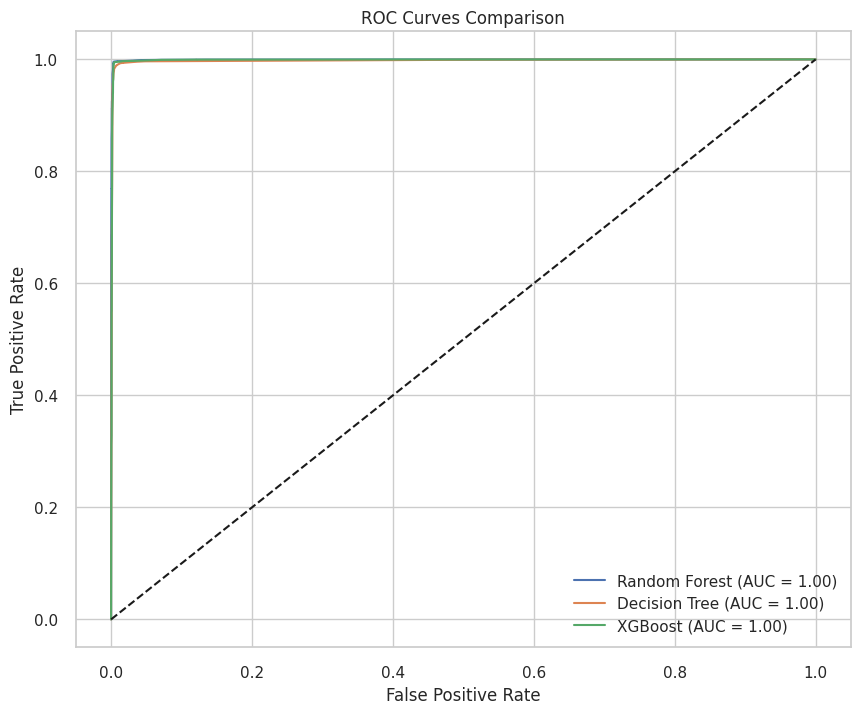

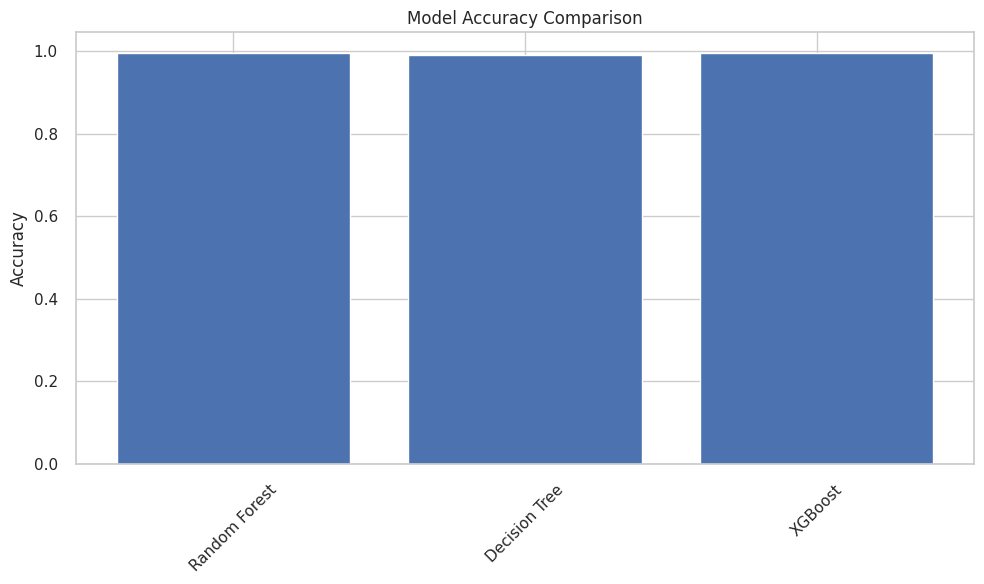

In [68]:
plt.figure(figsize=(10, 8))
for name, result in results.items():
    if result['fpr'] is not None:
        plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.show()


accuracies = {name: result['accuracy'] for name, result in results.items()}
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values())
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
weights = {
    'accuracy': 0.3,
    'cv_mean': 0.3,
    'auc': 0.4
}


model_scores = {}
for name, result in results.items():
    try:
        weighted_accuracy = result['accuracy'] * weights['accuracy']
        weighted_cv = result['cv_mean'] * weights['cv_mean']
        weighted_auc = result['auc'] * weights['auc'] if result['auc'] is not None else 0
        
        total_score = weighted_accuracy + weighted_cv + weighted_auc
        
        model_scores[name] = {
            'total_score': total_score,
            'weighted_accuracy': weighted_accuracy,
            'weighted_cv': weighted_cv,
            'weighted_auc': weighted_auc
        }
    except Exception as e:
        print(f"Error calculating score for {name}: {e}")
        continue

best_model_name = max(model_scores.items(), key=lambda x: x[1]['total_score'])[0]
best_model = results[best_model_name]['model']


print("\nModel Comparison:")
print("=" * 50)
for name, scores in model_scores.items():
    print(f"\n{name}:")
    print(f"Total Score: {scores['total_score']:.4f}")
    print(f"Weighted Accuracy: {scores['weighted_accuracy']:.4f}")
    print(f"Weighted CV Score: {scores['weighted_cv']:.4f}")
    print(f"Weighted AUC: {scores['weighted_auc']:.4f}")

print(f"\nBest Model: {best_model_name}")
print(f"Best Model Score: {model_scores[best_model_name]['total_score']:.4f}")
print("\nBest Model Classification Report:")
print(results[best_model_name]['report'])

with open('packet_classifier.pkl', 'wb') as f:
    pickle.dump({
        'model': best_model,
        'scaler': scaler,
        'label_encoders': label_encoders,
        'feature_names': X.columns.tolist(),
        'model_name': best_model_name,
        'model_scores': model_scores[best_model_name]
    }, f)

print(f"\nBest model ({best_model_name}) saved as 'packet_classifier.pkl'")



Model Comparison:

Random Forest:
Total Score: 0.9972
Weighted Accuracy: 0.2987
Weighted CV Score: 0.2987
Weighted AUC: 0.3997

Decision Tree:
Total Score: 0.9926
Weighted Accuracy: 0.2969
Weighted CV Score: 0.2966
Weighted AUC: 0.3991

XGBoost:
Total Score: 0.9963
Weighted Accuracy: 0.2984
Weighted CV Score: 0.2984
Weighted AUC: 0.3995

Best Model: Random Forest
Best Model Score: 0.9972

Best Model Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     13782
           1       1.00      1.00      1.00    400550

    accuracy                           1.00    414332
   macro avg       0.95      1.00      0.97    414332
weighted avg       1.00      1.00      1.00    414332


Best model (Random Forest) saved as 'packet_classifier.pkl'


In [ ]:
def validate_training_data(data):
    """Validate input training data"""
    missing = [feat for feat in required_columns if feat not in data.columns]
    if missing:
        raise ValueError(f"Missing required features: {missing}")
    return True

def validate_prediction_data(data):
    """Validate input prediction data"""
    required_pred_columns = [col for col in required_columns if col != 'Label']
    missing = [feat for feat in required_pred_columns if feat not in data.columns]
    if missing:
        raise ValueError(f"Missing required features: {missing}")
    return True

def predict_packet(model_data, packet_data):
    """Predict single packet or batch of packets"""
    try:
        if isinstance(model_data, str):
            with open(model_data, 'rb') as f:
                model_data = pickle.load(f)
        
        packet_df = pd.DataFrame([packet_data]) if isinstance(packet_data, dict) else packet_data
        validate_prediction_data(packet_df)
        
        packet_df = engineer_packet_features(packet_df)
        
        columns_to_remove = ['sourcePort', 'destinationPort']
        packet_df = packet_df.drop(columns=[col for col in columns_to_remove if col in packet_df.columns])
        
        numeric_features = [col for col in packet_df.columns 
                          if packet_df[col].dtype in ['int64', 'float64']]
        packet_df[numeric_features] = model_data['scaler'].transform(packet_df[numeric_features])
        
        missing_cols = set(model_data['feature_names']) - set(packet_df.columns)
        for col in missing_cols:
            packet_df[col] = 0
        packet_df = packet_df[model_data['feature_names']]
        
        prediction = model_data['model'].predict(packet_df)
        probability = model_data['model'].predict_proba(packet_df)
        
        return {
            'prediction': prediction[0],
            'probability': probability[0].max(),
            'status': 'success'
        }
        
    except Exception as e:
        return {'status': 'error', 'message': str(e)}


In [46]:
example_packet = {
    'totalSourceBytes': 1551,
    'totalDestinationBytes': 2867,
    'totalDestinationPackets': 16,
    'totalSourcePackets': 13,
    'direction': 'R2L',
    'sourceTCPFlagsDescription': 'F,S,P,A',
    'destinationTCPFlagsDescription': 'F,S,P,A',
    'protocolName': 'tcp_ip',
    'sourcePort': 58374,
    'destinationPort': 22,
    'startDateTime': '2010-06-12 20:04:00',
    'stopDateTime': '2010-06-12 20:04:00'
}

print("\nTesting prediction with SSH attack packet:")
result = predict_packet('packet_classifier.pkl', example_packet)
print(result)


Testing prediction with SSH attack packet:
{'prediction': 0, 'probability': 0.9967938790409667, 'status': 'success'}


In [47]:
def preprocess_test_data(test_df, model_data):
    """Preprocess test data to match training features"""
    try:
        required_columns = [
            'totalSourceBytes', 'totalDestinationBytes', 
            'totalDestinationPackets', 'totalSourcePackets',
            'direction', 'sourceTCPFlagsDescription', 'destinationTCPFlagsDescription',
            'protocolName', 'sourcePort', 'destinationPort',
            'startDateTime', 'stopDateTime', 'Label'
        ]
        
        missing_cols = [col for col in required_columns if col not in test_df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns in test data: {missing_cols}")
        
        test_df = test_df[required_columns].copy()

        test_df = engineer_packet_features(test_df)
        
        columns_to_remove = ['sourcePort', 'destinationPort']
        test_df = test_df.drop(columns=[col for col in columns_to_remove if col in test_df.columns])
        
        for col in model_data['feature_names']:
            if col not in test_df.columns:
                test_df[col] = 0
        
        test_df = test_df[model_data['feature_names']]
        
        return test_df
    
    except Exception as e:
        print(f"Error preprocessing test data: {e}")
        raise

In [61]:
def analyze_suspicious_traffic(test_df, predictions, probabilities, threshold=0.8):
    """Analyze suspicious traffic patterns with focus on behavioral patterns"""
    try:
        analysis_df = pd.DataFrame({
            'predicted_label': predictions,
            'confidence': probabilities.max(axis=1)
        })
        
        suspicious = analysis_df[
            (analysis_df['predicted_label'] == 'Attack') & 
            (analysis_df['confidence'] >= threshold)
        ]
        
        summary = {
            'total_traffic': len(predictions),
            'total_attacks': len(suspicious),
            'attack_ratio': len(suspicious) / len(predictions) if len(predictions) > 0 else 0,
            'avg_attack_confidence': suspicious['confidence'].mean() if len(suspicious) > 0 else 0,
            'high_confidence_attacks': len(suspicious[suspicious['confidence'] > 0.9]),
            'medium_confidence_attacks': len(suspicious[(suspicious['confidence'] > 0.7) & (suspicious['confidence'] <= 0.9)]),
            'low_confidence_attacks': len(suspicious[suspicious['confidence'] <= 0.7])
        }
        
        return pd.DataFrame([summary])
        
    except Exception as e:
        print(f"Error in traffic analysis: {str(e)}")
        return pd.DataFrame([{
            'total_traffic': len(predictions),
            'total_attacks': 0,
            'error': str(e)
        }])


In [ ]:

def evaluate_model_on_test_data(model_path, test_csv_path):
    """Evaluate saved model on a test dataset"""
    try:
        print(f"Loading model from {model_path}")
        with open(model_path, 'rb') as f:
            model_data = pickle.load(f)
            
        print(f"Loading test data from {test_csv_path}")
        test_df = pd.read_csv(test_csv_path)
        original_labels = test_df['Label'].copy()  # Store original labels
        
        print("Preprocessing test data...")
        test_df = preprocess_test_data(test_df, model_data)
        
        numeric_features = test_df.select_dtypes(include=['int32', 'float32', 'int64', 'float64']).columns
        test_df[numeric_features] = model_data['scaler'].transform(test_df[numeric_features])
        
        print("Making predictions...")
        predictions = model_data['model'].predict(test_df)
        probabilities = model_data['model'].predict_proba(test_df)
        
        predicted_labels = model_data['label_encoders']['Label'].inverse_transform(predictions)
        

        conf_matrix = confusion_matrix(original_labels, predicted_labels)
        class_report = classification_report(original_labels, predicted_labels)
        
        fig = plt.figure(figsize=(20, 15))
        
        plt.subplot(2, 2, 1)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        
        plt.subplot(2, 2, 2)
        sns.countplot(x=predicted_labels)
        plt.title('Distribution of Predictions')
        plt.xlabel('Predicted Class')
        plt.ylabel('Count')
        
        plt.subplot(2, 2, 3)
        sns.histplot(probabilities.max(axis=1), bins=50)
        plt.title('Prediction Confidence Distribution')
        plt.xlabel('Probability')
        plt.ylabel('Count')
        
        plt.subplot(2, 2, 4)
        fpr, tpr, _ = roc_curve(predictions, probabilities[:, 1])
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
        plt.tight_layout()
        plt.show()
        

        print("\nModel Performance Summary")
        print("=" * 50)
        print("\nClassification Report:")
        print(class_report)
        

        accuracy = (predicted_labels == original_labels).mean() * 100
        print(f"\nOverall Accuracy: {accuracy:.2f}%")
        

        results_df = pd.DataFrame({
            'Original': original_labels,
            'Predicted': predicted_labels,
            'Confidence': probabilities.max(axis=1)
        })
        

        results_df.to_csv('model_evaluation_results.csv', index=False)
        print("\nDetailed results saved to 'model_evaluation_results.csv'")
        
        misclassified = results_df[results_df['Original'] != results_df['Predicted']]
        if len(misclassified) > 0:
            print("\nSample of Misclassified Instances:")
            print(misclassified.head())
            
        print("\nAnalyzing traffic patterns...")
        traffic_analysis = analyze_suspicious_traffic(test_df, predicted_labels, probabilities)
        
        if not traffic_analysis.empty:
            print("\nTraffic Analysis Summary:")
            print("=" * 50)
            metrics = ['total_traffic', 'total_attacks', 'attack_ratio', 
                      'avg_attack_confidence', 'high_confidence_attacks', 
                      'medium_confidence_attacks', 'low_confidence_attacks']
            
            for metric in metrics:
                if metric in traffic_analysis:
                    value = traffic_analysis[metric].iloc[0]
                    print(f"{metric.replace('_', ' ').title()}: {value:.4f}" if isinstance(value, float) 
                          else f"{metric.replace('_', ' ').title()}: {value}")
            
            #Visualize attack confidence distribution
            plt.figure(figsize=(12, 5))
            
            plt.subplot(1, 2, 1)
            conf_data = {
                'High (>0.9)': traffic_analysis['high_confidence_attacks'].iloc[0],
                'Medium (0.7-0.9)': traffic_analysis['medium_confidence_attacks'].iloc[0],
                'Low (<0.7)': traffic_analysis['low_confidence_attacks'].iloc[0]
            }
            plt.bar(conf_data.keys(), conf_data.values())
            plt.title('Attack Confidence Distribution')
            plt.ylabel('Number of Attacks')
            plt.xticks(rotation=45)
            
            plt.subplot(1, 2, 2)
            attack_ratio = traffic_analysis['attack_ratio'].iloc[0]
            plt.pie([attack_ratio, 1-attack_ratio], 
                   labels=['Attacks', 'Normal'], 
                   autopct='%1.1f%%')
            plt.title('Traffic Distribution')
            
            plt.tight_layout()
            plt.show()
        
        return results_df, traffic_analysis
        
    except Exception as e:
        print(f"Error in evaluation: {str(e)}")
        return None, None



Evaluating saved model on test dataset...
Loading model from packet_classifier.pkl
Loading test data from /kaggle/input/test-data/TestbedThuJun17Flows.csv
Preprocessing test data...
Making predictions...


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


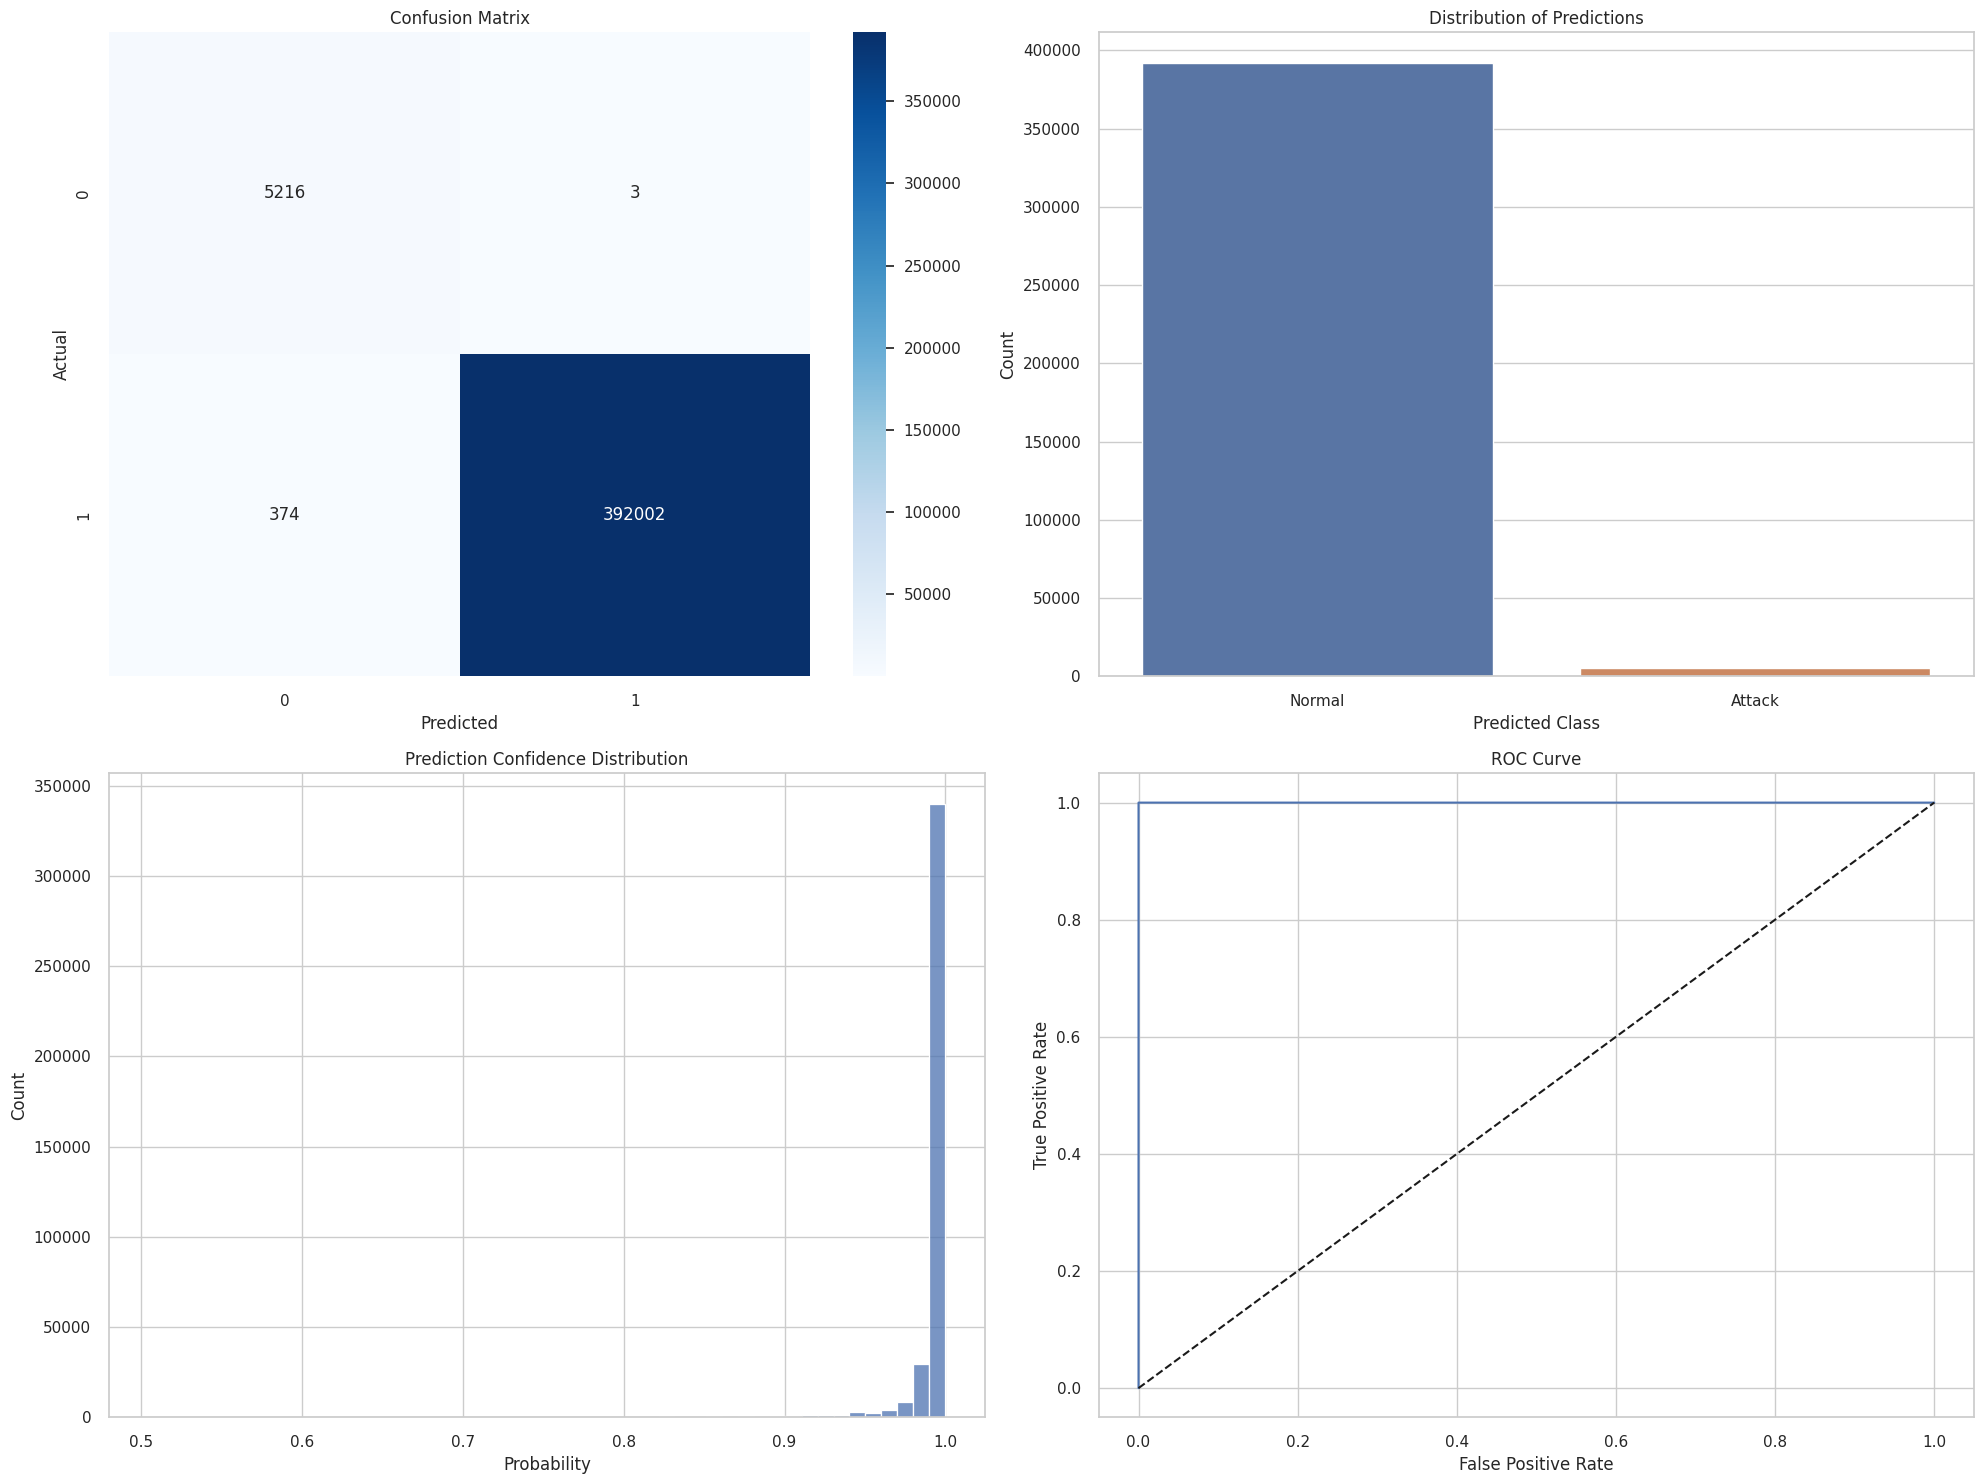


Model Performance Summary

Classification Report:
              precision    recall  f1-score   support

      Attack       0.93      1.00      0.97      5219
      Normal       1.00      1.00      1.00    392376

    accuracy                           1.00    397595
   macro avg       0.97      1.00      0.98    397595
weighted avg       1.00      1.00      1.00    397595


Overall Accuracy: 99.91%

Detailed results saved to 'model_evaluation_results.csv'

Sample of Misclassified Instances:
     Original Predicted  Confidence
1376   Normal    Attack    0.936311
3339   Normal    Attack    0.631529
5162   Normal    Attack    0.595515
7945   Normal    Attack    0.516659
9525   Normal    Attack    0.936311

Analyzing traffic patterns...

Traffic Analysis Summary:
Total Traffic: 397595
Total Attacks: 5281
Attack Ratio: 0.0133
Avg Attack Confidence: 0.9831
High Confidence Attacks: 4990
Medium Confidence Attacks: 291
Low Confidence Attacks: 0


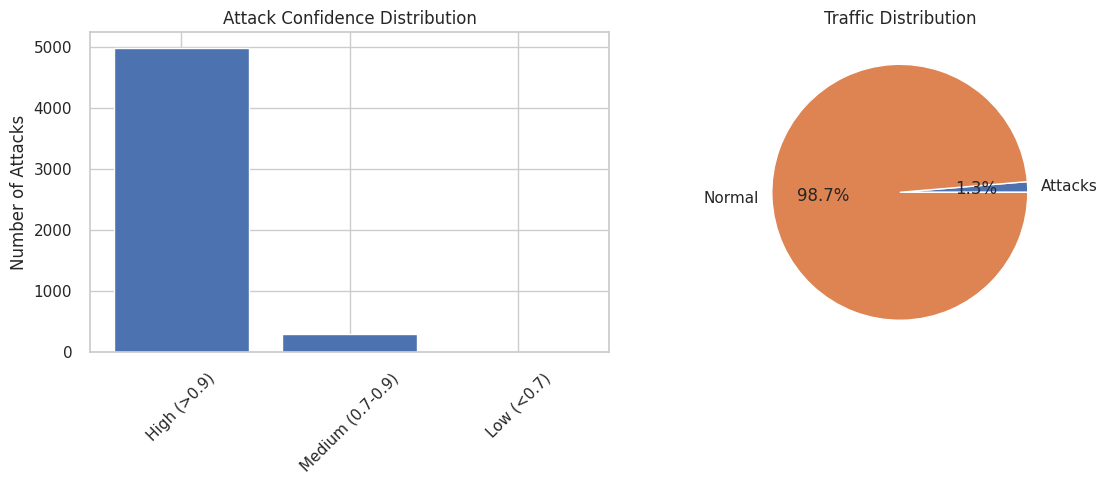


Traffic Analysis Summary:
Total Traffic: 397,595
Total Attacks: 5,281
Attack Ratio: 1.33%

Confidence Analysis:
------------------------------
Average Attack Confidence: 0.9831
High Confidence Attacks (>0.9): 4990.0000
Medium Confidence Attacks (0.7-0.9): 291.0000
Low Confidence Attacks (<0.7): 0.0000


In [71]:
test_dataset = "/kaggle/input/test-data/TestbedThuJun17Flows.csv"
print("\nEvaluating saved model on test dataset...")
evaluation_results, suspicious_patterns = evaluate_model_on_test_data('packet_classifier.pkl', test_dataset)

if suspicious_patterns is not None:
    try:
        print("\nTraffic Analysis Summary:")
        print("=" * 50)
        
        basic_metrics = {
            'Total Traffic': f"{int(suspicious_patterns['total_traffic'].iloc[0]):,d}",
            'Total Attacks': f"{int(suspicious_patterns['total_attacks'].iloc[0]):,d}",
            'Attack Ratio': f"{suspicious_patterns['attack_ratio'].iloc[0]:.2%}"
        }
        
        for metric, value in basic_metrics.items():
            print(f"{metric}: {value}")
        
        confidence_metrics = {
            'Average Attack Confidence': 'avg_attack_confidence',
            'High Confidence Attacks (>0.9)': 'high_confidence_attacks',
            'Medium Confidence Attacks (0.7-0.9)': 'medium_confidence_attacks',
            'Low Confidence Attacks (<0.7)': 'low_confidence_attacks'
        }
        
        print("\nConfidence Analysis:")
        print("-" * 30)
        for label, col in confidence_metrics.items():
            if col in suspicious_patterns.columns:
                value = suspicious_patterns[col].iloc[0]
                if 'confidence' in col.lower():
                    print(f"{label}: {value:.4f}")
                else:
                    print(f"{label}: {int(value):,d}")
                    
    except Exception as e:
        print(f"Error displaying traffic summary: {str(e)}")
        print("Available columns:", suspicious_patterns.columns.tolist())